# Solving 2D Ising model using GPU

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import scipy as sp
import torch as to
device = to.device('cuda' if to.cuda.is_available() else 'cpu')

#### Initializing Grids

In [2]:
N = 1000
random = to.rand((N,N)).to(device)
lat = to.zeros((N,N)).to(device)
lat[random >= 0.35 ] = 1
lat[random < 0.35 ] = -1
lat2 = lat.unsqueeze(0).unsqueeze(0)

#### Define a function to calculate energy, energy change at every position in the lattice and then sum energy at every position them to find total energy

##### For square Lattice

In [8]:
def energy_lat_gpu(lat):
    kernel = sp.ndimage.generate_binary_structure(2,1)
    kernel[1][1] = False

    kernel = to.tensor(kernel.astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device)

    en_lat = -lat * to.nn.functional.conv2d(lat, kernel, padding="same")

    energy = en_lat.sum(dim=(1,2,3))

    dE_array = -2 * en_lat
    return energy, en_lat, dE_array

In [9]:
def metro_alg_gpu(lat_2D, steps, BJ):
    device = lat_2D.device
    energies = []
    avg_spin = []
    lat = lat_2D.clone()
    BJ = BJ.reshape([-1,1,1,1])
    
    
    for t in range(steps):
        i = to.randint(0, 2, (), device=device).item()
        j = to.randint(0, 2, (), device=device).item()
        
        _, _, dE_arr = energy_lat_gpu(lat)
        dE = dE_arr[:,:, i::2, j::2]

        rand_vals = to.rand_like(dE, device=device)

        change = (dE >= 0) * (rand_vals < to.exp(-BJ*dE)) + (dE < 0)
        lat[:,:, i::2, j::2][change] *= -1

        E, _, _ = energy_lat_gpu(lat)
        energies.append(E)
        avg_spin.append(lat.sum((1,2,3)) / N**2)

    return to.vstack(avg_spin), to.vstack(energies)


##### For Triangular Lattice

In [10]:
def energy_lat_gpu_triang(lat):
    kernel = sp.ndimage.generate_binary_structure(2,1)
    kernel[1][1] = False
    kernel[0, 2] = 1 
    kernel[2, 0] = 1  
    kernel = to.tensor(kernel.astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device)
    en_lat = -lat * to.nn.functional.conv2d(lat, kernel, padding='same')

    energy = en_lat.sum(dim=(1,2,3))

    dE_array = -2 * en_lat
    return energy, en_lat, dE_array

In [30]:
def metro_alg_gpu_triang(lat_2D, steps, BJ):
    device = lat_2D.device
    energies = []
    avg_spin = []
    lat = lat_2D.clone()
    BJ = BJ.reshape([-1,1,1,1])
    
    
    for t in range(steps):
        i = to.randint(0, 4, (), device=device).item()
        j = to.randint(0, 4, (), device=device).item()
        
        _, _, dE_arr = energy_lat_gpu_triang(lat)
        dE = dE_arr[:,:, i::4, j::4]

        rand_vals = to.rand_like(dE, device=device)

        change = (dE >= 0) * (rand_vals < to.exp(-BJ*dE)) + (dE < 0)
        lat[:,:, i::4, j::4][change] *= -1

        E, _, _ = energy_lat_gpu(lat)
        energies.append(E)
        avg_spin.append(lat.sum((1,2,3)) / N**2)

    return to.vstack(avg_spin), to.vstack(energies)


## Feed the value of temperature to inverse BJ and the metropolis function for specfic lattice to get metropolis at that temperature

In [33]:
BJ =  0.85*to.ones(lat2.shape[0]).to(device)
avgspin , energy = metro_alg_gpu_triang(lat2,8000,BJ)

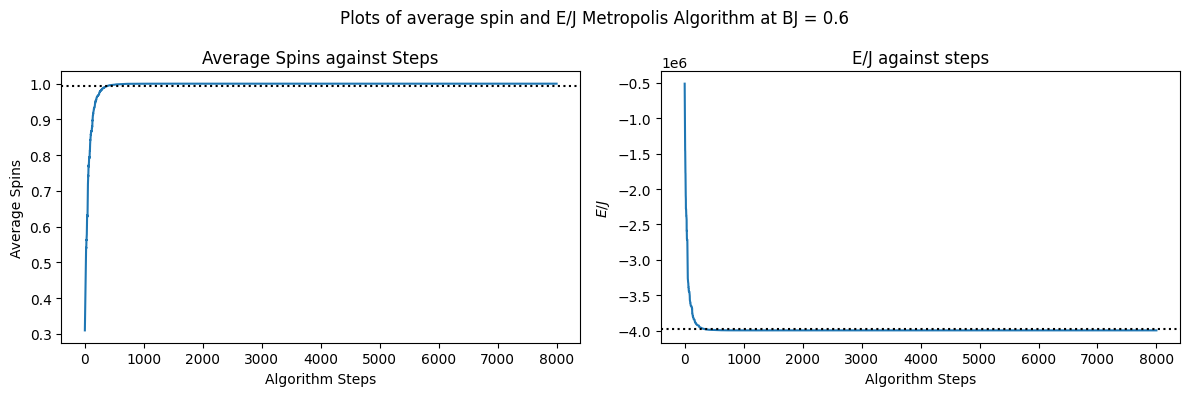

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(avgspin[:,0].cpu())
ax.set_xlabel('Algorithm Steps')
ax.set_ylabel(r'Average Spins')
ax.set_title('Average Spins against Steps')
ax.axhline((avgspin[:,0].cpu()).mean() , color = 'black',linestyle='dotted')
ax = axes[1]
ax.plot(energy[:,0].cpu())
ax.set_xlabel('Algorithm Steps')
ax.set_ylabel(r'$E/J$')
ax.set_title('E/J against steps')
ax.axhline((energy[:,0].cpu()).mean() , color = 'black',linestyle='dotted')
fig.suptitle('Plots of average spin and E/J Metropolis Algorithm at BJ = 0.6')
fig.tight_layout()
plt.show()

### Plotting quantities at different temperatures for square lattice

In [22]:
def MES_metro_gpu(lat,BJ,steps=10000):
    N = (lat.shape[-1])
    lat = lat.unsqueeze(dim=0).repeat(len(BJ),1,1,1)
    spins, energies = metro_alg_gpu(lat, steps, BJ)
    tail = int(0.2 * steps)
    avg_spin = spins[-tail:].mean(dim=0)
    mag_sus = (spins[-tail:].std(dim=0))**2/N**2
    energies_avg = energies[-tail:].mean(dim=0)
    heat_cap = ((energies[-tail:].std(dim=0))**2)/N**2
    
    return avg_spin, mag_sus, energies_avg, heat_cap

### Plotting quantities at different temperatures for triangular lattice

In [35]:
def MES_metro_gpu_triang(lat,BJ,steps=10000):
    N = (lat.shape[-1])
    lat = lat.unsqueeze(dim=0).repeat(len(BJ),1,1,1)
    spins, energies = metro_alg_gpu_triang(lat, steps, BJ)
    tail = int(0.2 * steps)
    avg_spin = spins[-tail:].mean(dim=0)
    mag_sus = (spins[-tail:].std(dim=0))**2/N**2
    energies_avg = energies[-tail:].mean(dim=0)
    heat_cap = ((energies[-tail:].std(dim=0))**2)/N**2
    
    return avg_spin, mag_sus, energies_avg, heat_cap

In [48]:
BJs = to.linspace(0.2,1,40).to(device)
spins_avg,mag_sus, E_means, heat_cap = MES_metro_gpu_triang(lat, BJs,6000)

#### Plotting the quantities.

<function matplotlib.pyplot.show(close=None, block=None)>

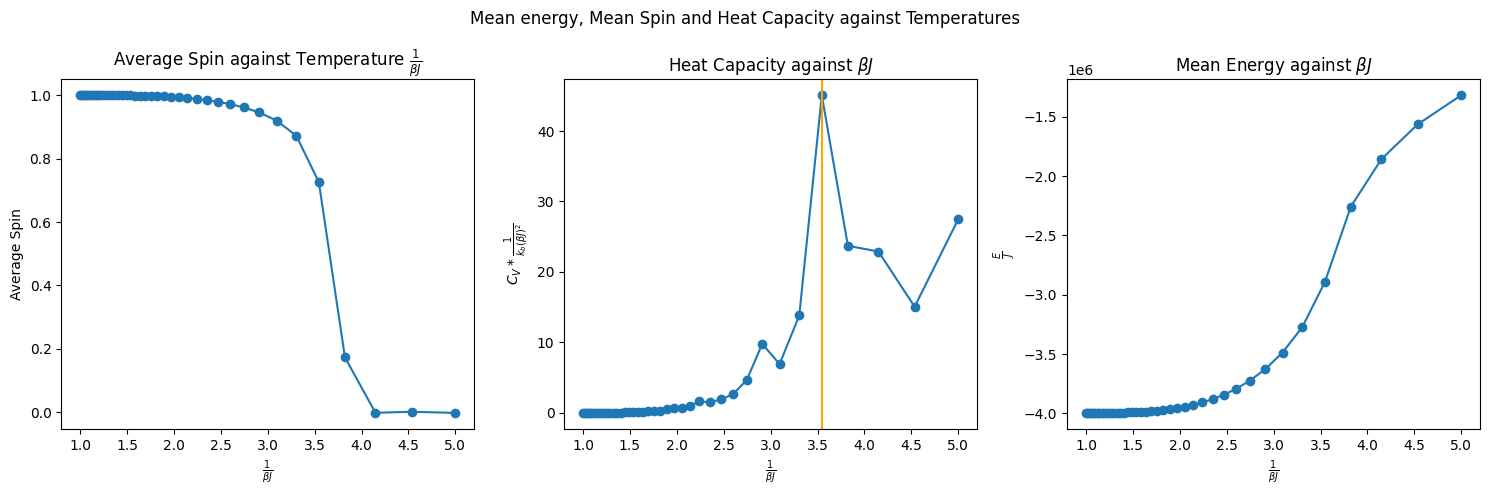

In [53]:
fig , axes = plt.subplots(1,3 , figsize = (15 , 5))
ax = axes[0]
ax.plot(1/BJs.cpu(), spins_avg.cpu(),marker = 'o')
ax.set_xlabel(r'$\frac{1}{\beta J}$')
ax.set_ylabel('Average Spin')
ax.set_title(r'Average Spin against Temperature $\frac{1}{\beta J}$')

ax = axes[1]
ax.plot(1/BJs.cpu(), (heat_cap.cpu()),marker = 'o')
ax.set_xlabel(r'$ \frac{1}{\beta J}$')
ax.set_ylabel(r'$C_V * \frac{1}{k_b (\beta J)^2}$')
ax.set_title(r"Heat Capacity against $\beta J$")
peak1 = np.argmax(heat_cap.cpu())
in_T = 1/BJs.cpu()
peak = in_T[peak1]
ax.axvline(peak , color ='orange')

ax = axes[2]
ax.plot(1/BJs.cpu(), E_means.cpu(),marker = 'o')
ax.set_xlabel(r'$ \frac{1}{\beta J}$')
ax.set_ylabel(r'$ \frac{E}{J}$ ')
ax.set_title(r"Mean Energy against $\beta J$")

fig.suptitle('Mean energy, Mean Spin and Heat Capacity against Temperatures')
fig.tight_layout()
plt.savefig(r"C:\Users\dellg\Desktop\submission\metropolis_plot_gpu_triang.png", dpi=300)
plt.show

In [52]:
Error_triang = ((3.604 - peak)/3.604) * 100
print(f"The critical temperature was '{peak:.4f}' and the error was '{Error_triang:.4f}'")

The critical temperature was '3.5455' and the error was '1.6245'
